## Appendix B: Models and Evaluation Metrics

### Libraries

In [91]:
import pandas as pd
from statistics import mode
import os
import seaborn as sn
import matplotlib.pylab as plt
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from dmba import classificationSummary, gainsChart
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc

### Loading in Data

In [2]:
DATA_ROOT = 'C:/Users/mzazu/OneDrive/Documents/USD papers/505/505Project/application_train.csv'
credit_df = pd.read_csv(os.path.join(DATA_ROOT, 'credit_df.csv'))

### Modeling

#### Partition the dataset into 60% training, 20% validation, and 20% test

In [3]:
X = credit_df.drop(columns=['TARGET'])
y = credit_df['TARGET']
train_X, rem_X, train_y, rem_y = train_test_split(X, y, train_size=0.6, random_state=42, stratify = y)
valid_X, test_X, valid_y, test_y = train_test_split(rem_X, rem_y, train_size=0.5, random_state=42, stratify = rem_y)

In [12]:
print('Training Set:\n', train_y.value_counts(), '\n', train_y.value_counts(normalize = True))
print('\nValidation Set:\n', valid_y.value_counts(), '\n', valid_y.value_counts(normalize = True))
print('\nTest Set:\n', test_y.value_counts(), '\n', test_y.value_counts(normalize = True))

Training Set:
 0    169611
1     14895
Name: TARGET, dtype: int64 
 0    0.919271
1    0.080729
Name: TARGET, dtype: float64

Validation Set:
 0    56537
1     4965
Name: TARGET, dtype: int64 
 0    0.919271
1    0.080729
Name: TARGET, dtype: float64

Test Set:
 0    56538
1     4965
Name: TARGET, dtype: int64 
 0    0.919272
1    0.080728
Name: TARGET, dtype: float64


##### Resampling training set

In [4]:
# Fixing the class imbalance with tomekLinks and SMOTE
SMOTEtl = SMOTETomek(random_state = 42)

# fit predictor and target variable for training set only
train_X_res, train_y_res = SMOTEtl.fit_resample(train_X, train_y)

print('Original dataset shape:\n', train_y.value_counts())
print('Resampled dataset shape:\n', train_y_res.value_counts())

Original dataset shape:
 0    169611
1     14895
Name: TARGET, dtype: int64
Resampled dataset shape:
 1    166796
0    166796
Name: TARGET, dtype: int64


##### Helper function

In [5]:
def confusionMatrices(model, title):
    print(title + ' - training results')
    classificationSummary(train_y_res, model.predict(train_X_res))
    print(title + ' - validation results')
    valid_pred = model.predict(valid_X)
    classificationSummary(valid_y, valid_pred)

#### Logistic regression

In [59]:
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear', random_state = 1)
logit_reg.fit(train_X_res, train_y_res)
confusionMatrices(logit_reg, 'Logistic regression')

Logistic regression - training results
Confusion Matrix (Accuracy 0.5486)

       Prediction
Actual     0     1
     0 98161 68635
     1 81962 84834
Logistic regression - validation results
Confusion Matrix (Accuracy 0.5796)

       Prediction
Actual     0     1
     0 33071 23466
     1  2388  2577


##### Test Set

In [60]:
logit_pred = logit_reg.predict(test_X)
classificationSummary(test_y, logit_pred)

Confusion Matrix (Accuracy 0.5789)

       Prediction
Actual     0     1
     0 33031 23507
     1  2394  2571


##### Evaluation Metrics

In [61]:
# precision tp / (tp + fp)
precision = precision_score(test_y, logit_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_y, logit_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_y, logit_pred)
print('F1 score: %f' % f1)
# ROC AUC
lr_probs = logit_reg.predict_proba(test_X)
lr_probs = lr_probs[:, 1]
auc = roc_auc_score(test_y, lr_probs)
print('ROC AUC: %f' % auc)

Precision: 0.098589
Recall: 0.517825
F1 score: 0.165641
ROC AUC: 0.568793


#### Bagging

In [56]:
bagging = BaggingClassifier( max_samples=0.5, max_features=0.5, random_state = 1)
bagging.fit(train_X_res, train_y_res)
confusionMatrices(bagging, 'Bagged Decision tree')

Bagged Decision tree - training results
Confusion Matrix (Accuracy 0.9759)

       Prediction
Actual      0      1
     0 166685    111
     1   7936 158860
Bagged Decision tree - validation results
Confusion Matrix (Accuracy 0.9124)

       Prediction
Actual     0     1
     0 55992   545
     1  4841   124


##### Test Set

In [57]:
bagging_pred = bagging.predict(test_X)
classificationSummary(test_y, bagging_pred)

Confusion Matrix (Accuracy 0.9130)

       Prediction
Actual     0     1
     0 56033   505
     1  4845   120


##### Evaluation Metrics

In [58]:
# precision tp / (tp + fp)
precision = precision_score(test_y, bagging_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_y, bagging_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_y, bagging_pred)
print('F1 score: %f' % f1)
# ROC AUC
bg_probs = bagging.predict_proba(test_X)
bg_probs = bg_probs[:, 1]
auc = roc_auc_score(test_y, bg_probs)
print('ROC AUC: %f' % auc)

Precision: 0.192000
Recall: 0.024169
F1 score: 0.042934
ROC AUC: 0.598841


#### Adaboost

In [53]:
adaboost = AdaBoostClassifier(n_estimators=50,  random_state = 1)
adaboost.fit(train_X_res, train_y_res)
confusionMatrices(adaboost, 'Boosted decision tree')

Boosted decision tree - training results
Confusion Matrix (Accuracy 0.9142)

       Prediction
Actual      0      1
     0 153429  13367
     1  15255 151541
Boosted decision tree - validation results
Confusion Matrix (Accuracy 0.8595)

       Prediction
Actual     0     1
     0 52016  4521
     1  4120   845


##### Test Set

In [54]:
adaboost_pred = adaboost.predict(test_X)
classificationSummary(test_y, adaboost_pred)

Confusion Matrix (Accuracy 0.8609)

       Prediction
Actual     0     1
     0 52112  4426
     1  4127   838


##### Evaluation Metrics

In [55]:
# precision tp / (tp + fp)
precision = precision_score(test_y, adaboost_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_y, adaboost_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_y, adaboost_pred)
print('F1 score: %f' % f1)
# ROC AUC
ab_probs = adaboost.predict_proba(test_X)
ab_probs = ab_probs[:, 1]
auc = roc_auc_score(test_y, ab_probs)
print('ROC AUC: %f' % auc)

Precision: 0.159195
Recall: 0.168781
F1 score: 0.163848
ROC AUC: 0.655630


#### Random Forest

In [30]:
RandomForest = RandomForestClassifier(n_estimators=500, random_state=1, max_depth = 6)
RandomForest.fit(train_X_res, train_y_res)
confusionMatrices(RandomForest, 'Random Forest')

Random Forest - training results
Confusion Matrix (Accuracy 0.8906)

       Prediction
Actual      0      1
     0 151105  15691
     1  20812 145984
Random Forest - validation results
Confusion Matrix (Accuracy 0.8489)

       Prediction
Actual     0     1
     0 51139  5398
     1  3895  1070


##### Test Set

In [31]:
RandomForest_pred = RandomForest.predict(test_X)
classificationSummary(test_y, RandomForest_pred)

Confusion Matrix (Accuracy 0.8522)

       Prediction
Actual     0     1
     0 51309  5229
     1  3860  1105


##### Evaluation Metrics

In [51]:
# precision tp / (tp + fp)
precision = precision_score(test_y, RandomForest_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_y, RandomForest_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_y, RandomForest_pred)
print('F1 score: %f' % f1)
# ROC AUC
rf_probs = RandomForest.predict_proba(test_X)
rf_probs = rf_probs[:, 1]
auc = roc_auc_score(test_y, rf_probs)
print('ROC AUC: %f' % auc)

Precision: 0.174455
Recall: 0.222558
F1 score: 0.195593
ROC AUC: 0.668388


#### Linear discriminant analysis


In [62]:
lda_Model = LinearDiscriminantAnalysis()
lda_Model.fit(train_X_res, train_y_res)
confusionMatrices(lda_Model, 'Linear discriminant analysis')

Linear discriminant analysis - training results
Confusion Matrix (Accuracy 0.9421)

       Prediction
Actual      0      1
     0 165581   1215
     1  18096 148700
Linear discriminant analysis - validation results
Confusion Matrix (Accuracy 0.9144)

       Prediction
Actual     0     1
     0 56122   415
     1  4850   115


##### Test Set

In [63]:
lda_Model_pred = lda_Model.predict(test_X)
classificationSummary(test_y, lda_Model_pred)

Confusion Matrix (Accuracy 0.9147)

       Prediction
Actual     0     1
     0 56149   389
     1  4856   109


##### Evaluation Metrics

In [64]:
# precision tp / (tp + fp)
precision = precision_score(test_y, lda_Model_pred )
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_y, lda_Model_pred )
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_y, lda_Model_pred )
print('F1 score: %f' % f1)
# ROC AUC
lda_probs = lda_Model.predict_proba(test_X)
lda_probs = lda_probs[:, 1]
auc = roc_auc_score(test_y, lda_probs)
print('ROC AUC: %f' % auc)

Precision: 0.218876
Recall: 0.021954
F1 score: 0.039905
ROC AUC: 0.639864


#### Neural Network

In [10]:
neuralNet = MLPClassifier(hidden_layer_sizes=(5), activation='logistic', solver='lbfgs', max_iter=2000, 
                          random_state=1)
neuralNet.fit(train_X_res, train_y_res)
confusionMatrices(neuralNet, 'Neural Network')

Neural Network - training results
Confusion Matrix (Accuracy 0.5389)

       Prediction
Actual      0      1
     0  63794 103002
     1  50827 115969
Neural Network - validation results
Confusion Matrix (Accuracy 0.4064)

       Prediction
Actual     0     1
     0 21588 34949
     1  1556  3409


##### Test Set

In [11]:
neuralNet_pred = neuralNet.predict(test_X)
classificationSummary(test_y, neuralNet_pred )

Confusion Matrix (Accuracy 0.4112)

       Prediction
Actual     0     1
     0 21822 34716
     1  1499  3466


##### Evaluation Metrics

In [65]:
# precision tp / (tp + fp)
precision = precision_score(test_y, neuralNet_pred )
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_y, neuralNet_pred )
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_y, neuralNet_pred )
print('F1 score: %f' % f1)
# ROC AUC
nn_probs = neuralNet.predict_proba(test_X)
nn_probs = nn_probs[:, 1]
auc = roc_auc_score(test_y, nn_probs)
print('ROC AUC: %f' % auc)

Precision: 0.090776
Recall: 0.698087
F1 score: 0.160660
ROC AUC: 0.542171


### Final Model Selection: Random Forest

#### ROC Curve

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.668


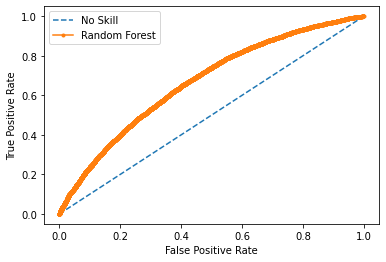

In [49]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(test_y))]
# calculate scores
ns_auc = roc_auc_score(test_y, ns_probs)
rf_auc = roc_auc_score(test_y, rf_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_y, rf_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#### Lift Charts

<AxesSubplot:title={'center':'Bagging'}, xlabel='# records', ylabel='# cumulative gains'>

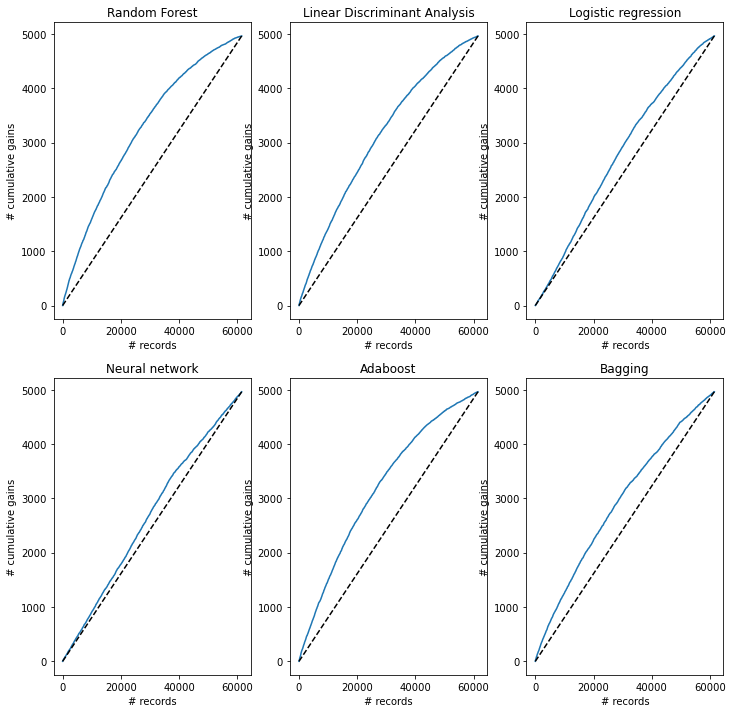

In [93]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 12))

def modelGainsChart(model, title, ax=None):
    result = pd.DataFrame({
        'actual': test_y,
        'prob': model.predict_proba(test_X)[:, 1]
    })

    result = result.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    ax = gainsChart(result.actual, ax=ax)
    ax.set_title(title)
    return ax

modelGainsChart(RandomForest, 'Random Forest', axes[0,0])
modelGainsChart(lda_Model, 'Linear Discriminant Analysis', axes[0,1])
modelGainsChart(logit_reg, 'Logistic regression', axes[0,2])
modelGainsChart(neuralNet, 'Neural network', axes[1,0])
modelGainsChart(adaboost, 'Adaboost', axes[1,1])
modelGainsChart(bagging, 'Bagging', axes[1,2])